In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from pyomo.environ import *
from pyomo.util.infeasible import log_infeasible_constraints
import logging
import pickle

from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from functools import partial

# Prep and load the data

In [3]:
datapath = Path(Path().cwd().parents[3]) / 'EGU23' / 'data'
savepath = datapath / 'Forecasts' / 'Scenarios'


In [4]:
def check_min_len(df: pd.DataFrame, max_nan_frac=0.3):
    cols = [col for col in df.columns if 1-(len(df.loc[:,col].dropna().index)/len(df.loc[:,col].index)) < max_nan_frac]
    return df.loc[:,cols].interpolate(method='time')

In [5]:
def read_wb(wb):
    Q = pd.read_csv(datapath / 'waterboards' / ('Q_'+wb.upper()+'.csv'), index_col=0, parse_dates=True).astype(np.float64).resample('1H').mean()
    if wb != 'Rijnland':
        Q.loc[:, 'Aggregated'] = Q.sum(axis=1)
    else:
        Q.loc[:, 'Aggregated'] = Q.loc[:, ['Halfweg', 'Spaarndam']].sum(axis=1)
    Q = check_min_len(Q)

    Q = Q.loc[:, ['Aggregated']]
    return Q

In [6]:
discharge_scenarios = pd.read_csv(savepath / 'discharge_scenarios.csv', index_col=[0,1], parse_dates=True)
actual_wb_discharge = {wb: read_wb(wb) for wb in ['Waternet', 'HDSR', 'HHNK', 'Rijnland']}

In [7]:
idx = pd.IndexSlice

In [8]:
actual_discharge = pd.concat(actual_wb_discharge, axis=1, keys=actual_wb_discharge.keys())
actual_discharge = actual_discharge.loc[:, pd.IndexSlice[:, 'Aggregated']]
actual_discharge.columns = actual_discharge.columns.droplevel(1)
actual_discharge = actual_discharge.dropna().sum(axis=1).round(2)

In [9]:
waterlevel_scenarios = pd.read_csv(savepath / 'wl_scenarios.csv', index_col=[0,1], parse_dates=True) / 100
actual_waterlevel = pd.read_csv(datapath/'waterlevel'/'IJmuiden Noordersluis.csv', index_col=0, parse_dates=True).astype(np.float64).resample('1H').mean() / 100
actual_waterlevel.columns = ['WL']
actual_waterlevel.loc[actual_waterlevel.WL > 1000, 'WL'] = np.nan	# Remove outliers
actual_waterlevel = check_min_len(actual_waterlevel)

In [10]:
dam_scenarios = pd.read_csv(savepath / 'dam_scenarios.csv', index_col=[0,1], parse_dates=True)
actual_dam = pd.read_pickle(datapath / 'market data' / 'DAM_prices.pkl').loc[:, 'NL']

In [11]:
ind_ = pd.date_range(discharge_scenarios.index.levels[0].unique()[0] + pd.DateOffset(hours=1) - pd.DateOffset(days=1), periods=len(dam_scenarios.index.levels[0].unique()), freq='1D')
new_ind = pd.MultiIndex.from_product([ind_, range(5)], names=['date', 'scenario'])
dam_scenarios.index = new_ind

## Linearize pump power using Delaunay triangulation and linearizations per triangle

In [12]:
def pump_power(dh, q):
    a = 0.033
    b = 0.061
    c = 11.306

    return (a * q ** 2 + b * dh**2 \
        * q + c * q * dh) / 1000  # kWh -> MW

def QH_pump(dh):
    return (-3.9764*(dh)**2 - 17.7244*(dh) + 269.58)

dh = np.arange(0, 6.51, 0.01)
q = np.arange(0, 261, 1)

In [13]:
class LinearPump():
    def __init__(self, dh_max=6.5, q_max=260, dh_step=0.01, q_step=1, n_bins=10):
        self.n_bins = n_bins
        self.dh_max = dh_max
        self.q_max = q_max
        self.dh_step = dh_step
        self.q_step = q_step

        self.linegrids = self._make_linegrids()
        self.points = np.vstack(np.meshgrid(*self.linegrids)).reshape(2, -1).T
        self.tri = Delaunay(self.points)
        self.filter_infeasible_simplice_ids()

        self.linear_grid = self._get_linearization_grid()

    def q_h_pump(self, dh):
        return (-3.9764*(dh)**2 - 17.7244*(dh) + 269.58)

    def filter_infeasible_simplice_ids(self):
        """
        Filters the simplices that are (partially) outside the feasible range.
        """
        self.simplices = []
        for simplice_id in range(len(self.tri.simplices)):
            v1, v2, v3 = self.tri.simplices[simplice_id]
            dh1, q1 = self.points[v1]
            dh2, q2 = self.points[v2]
            dh3, q3 = self.points[v3]

            q_con1 = self.q_h_pump(dh1)
            q_con2 = self.q_h_pump(dh2)
            q_con3 = self.q_h_pump(dh3)

            if (dh1 > self.dh_max) & (dh2 > self.dh_max) & (dh3 > self.dh_max):
                continue
            if (q1 > q_con1) & (q2 > q_con2) & (q3 > q_con3):
                continue
            self.simplices.append(simplice_id)

    def _pump_power(self, dh, q):
        a = 0.033
        b = 0.061
        c = 11.306

        return (a * q ** 2 + b * dh**2 * q + c * q * dh) / 1000  # kW -> MW

    def _make_linegrids(self):
        return [np.linspace(0, self.dh_max, self.n_bins), np.linspace(0, self.q_max, self.n_bins)]
    
    def _get_linearization(self, simplice):
        # First get the vertices of the simplice
        v1, v2, v3 = simplice

        # Get the coordinates of the vertices
        dh1, q1 = self.points[v1]
        dh2, q2 = self.points[v2]
        dh3, q3 = self.points[v3]

        # Calculate the power for each vertex
        p1 = self._pump_power(dh1, q1)
        p2 = self._pump_power(dh2, q2)
        p3 = self._pump_power(dh3, q3)

        # Return the coefficients of the linearization (a, b, c) (a*dh + b*q + c = p)
        return np.linalg.solve(np.array([[dh1, q1, 1], [dh2, q2, 1], [dh3, q3, 1]]), np.array([p1, p2, p3]))

    def _get_linearization_grid(self):
        # Get the linearization for each simplice
        return np.array([self._get_linearization(simplice) for simplice in self.tri.simplices])

    def _make_binary_indicator_constraint(self, model, s_q, s_wl, t, simplice_id, big_m=17):
        """"
        Makes a Big-M constraint to indicate whether a point is inside a simplice or not.
        Takes a pyomo model object, and the index of the simplice (i) as input.
        We assume the binary variable name is B_lin_qph.
        
        Parameters
        ----------
        model : pyomo model object
            The model to which the constraint should be added.
        i : int
            The index of the simplice.

        returns: dictionary containing pyomo constraint expressions for all binary variables in this scenario and simplice.
            The dictionary has the following structure:
            {'alpha': {'upper': pyomo expression, 'lower': pyomo expression},
                    'beta': {'upper': pyomo expression, 'lower': pyomo expression},
                    'gamma': {'upper': pyomo expression, 'lower': pyomo expression},
                    'indicator': pyomo expression}
        """
        
        dh = model.pump_head[s_q, s_wl, t]
        q = model.q_pump[t]
                    
        # Add Big-M constraint to indicate whether the point is inside the simplice or not
        # If dh0 <= dh <= dh1 and q0 <= q <= q1, then B_lin_qph = 1
        # If dh < dh0 or dh > dh1 or q < q0 or q > q1, then B_lin_qph = 0

        # Get the vertices of the simplice
        v1, v2, v3 = self.tri.simplices[simplice_id-1]

        # Get the coordinates of the vertices
        dh1, q1 = self.points[v1]
        dh2, q2 = self.points[v2]
        dh3, q3 = self.points[v3]

        # Only add the constraint if the simplice is (partially) inside the feasible range
        if not (dh1 > self.dh_max) & (dh2 > self.dh_max) & (dh3 > self.dh_max):
            return {'alpha': {'upper': None, 'lower': None}, 'beta': {'upper': None, 'lower': None}, 'gamma': {'upper': None, 'lower': None}, 'indicator': None}

        if not (q1 > self.q_max) & (q2 > self.q_max) & (q3 > self.q_max):
            return {'alpha': {'upper': None, 'lower': None}, 'beta': {'upper': None, 'lower': None}, 'gamma': {'upper': None, 'lower': None}, 'indicator': None}

        # Calculate the weight vectors describing point (dh, q) relative the first point of the simplice
        alpha = dh1 * (q3 - q1) + (q - q1) * (dh3 - dh1) - dh * (q3 - q1)
        beta = (q - q1 - (alpha * (q2 - q1))) / (q3 - q1)
        gamma = 1 - alpha - beta

        # Constrain indicator variable to be 1 if w1 >= 0, w2 >= 0 and w1 + w2 <= 1
        # If w1 >= 0, B=1
        w1_con = w1 - (1 - model.B_lin_qph[s_q, s_wl, t, simplice_id, 1]) * big_m >= 0


        # Formulate the expressions
        # First the alpha big - M:
        alpha_max_ = big_m
        beta_max_ = big_m
        gamma_max_ = big_m
        
        expressions = {'alpha': {}, 'beta': {}, 'gamma': {}, 'indicator': None}
        # If alpha >= 0 -> B = free, if alpha < 0 -> B = 0
        upper_a = (alpha - 0) + alpha_max_ * (1 - model.B_lin_qph[s_q, s_wl, t, simplice_id, 1]) >= 0
        # If alpha > 0 -> B = 1, if alpha <= 0 -> B = free
        lower_a = (alpha - 0) - (model.B_lin_qph[s_q, s_wl, t, simplice_id, 1] * alpha_max_) <= 0

        expressions['alpha']['upper'] = upper_a
        expressions['alpha']['lower'] = lower_a

        upper_b = (beta - 0) + (1 - model.B_lin_qph[s_q, s_wl, t, simplice_id, 2]) * beta_max_ >= 0
        lower_b = (beta - 0) - (model.B_lin_qph[s_q, s_wl, t, simplice_id, 2] * beta_max_) <= 0
        expressions['beta']['upper'] = upper_b
        expressions['beta']['lower'] = lower_b

        upper_g = (gamma - 0) + (1 - model.B_lin_qph[s_q, s_wl, t, simplice_id, 3]) * gamma_max_ >= 0
        lower_g = (gamma - 0) - (model.B_lin_qph[s_q, s_wl, t, simplice_id, 3] * gamma_max_) <= 0
        expressions['gamma']['upper'] = upper_g
        expressions['gamma']['lower'] = lower_g

        # indicator = sum(model.B_lin_qph[s_q, s_wl, t, simplice_id, i] for i in range(1, 4)) - 3*model.B_lin_qph[s_q, s_wl, t, simplice_id, 4] <= 0
        # expressions['indicator'] = indicator
        return expressions
                    

    def _make_linear_constraint_dict(self, model):
        """
        Makes a dictionary containing the linearization constraints for each simplice and all scenarios and timesteps.
        The dictionary has the following structure:
        {(s_q, s_wl, t, simplice_id): {'alpha': {'upper': pyomo expression, 'lower': pyomo expression},
                                        'beta': {'upper': pyomo expression, 'lower': pyomo expression},
                                        'gamma': {'upper': pyomo expression, 'lower': pyomo expression},
                                        'indicator': pyomo expression}}

        Parameters
        ----------
        model : pyomo model object
            The model to which the constraints should be added.

        Returns
        -------
        constraint_dict : dictionary
            Dictionary containing the constraints.
        """
        constraint_dict = {}
        for s_q in model.discharge_scenarios:
            for s_wl in model.waterlevel_scenarios:
                for t in model.time:
                    for simplice_id in self.simplices:
                        constraint_dict[s_q, s_wl, t, simplice_id] = self._make_binary_indicator_constraint(model, s_q, s_wl, t, simplice_id)

        return constraint_dict

                    

    

In [13]:
# lin_pump.simplices

In [14]:
lin_pump = LinearPump()
# lin_pump.linear_grid

In [14]:
class ControlModel():
    # Robust for WL, only flex is from gate.
    # Max Qgate is decided based on all WL scenarios for 1 Q scenario
    def __init__(self, discharge_scenarios, waterlevel_scenarios, dam_scenarios, actual_discharge, actual_waterlevel, actual_dam, cvar_alpha=0.99):
        self.discharge_scenarios = discharge_scenarios.astype(float)
        self.waterlevel_scenarios = waterlevel_scenarios.astype(float)
        self.dam_scenarios = dam_scenarios.astype(float)
        self.actual_discharge = actual_discharge.astype(float)
        self.actual_waterlevel = actual_waterlevel.astype(float)
        self.actual_dam = actual_dam.astype(float)
        self.n_stages = 1
        self.h_now = -0.399
        self.q_pump_now = 0
        self.q_gate_now = 0
        self.idx = pd.IndexSlice
        self.lin_qh_pump_coefs = [{'a': -27.704394598829527, 'b': 269.58}, {'a': -45.718880015502684, 'b': 314.7928727389325}, {'a': -60.79565308467317, 'b': 383.09593797006175}]
        self.lin_qh_gate_coefs = [860.2111712656084, 153.33712985092018]
        self.alpha_wl = cvar_alpha

        self.n_bins_linqph = 3
        self.linear_pump = LinearPump(dh_max=6.5, q_max=260, dh_step=0.01, q_step=1, n_bins=self.n_bins_linqph)
        self.linear_coefficients = self.linear_pump.linear_grid
        self.linear_coef_dict = {i: self.linear_coefficients[i] for i in range(self.linear_coefficients.shape[0])}
        # TO DO: filtes linear coef dict and simplices for feasible range

        self.q_pump = {}
        self.q_gate = {}
        self.h_nzk = {}
        self.B_gate = {}
        self.B_pump = {}
        self.VaR_wl = {}
        self.z_wl = {}
        self.pump_head = {}
        self.pump_power = {}
        self.B_lin_qph = {}
    
    def create_model(self, date):
        q_scen = self.discharge_scenarios.loc[self.idx[date, :], [col for col in self.discharge_scenarios.columns if col != 'weights']].round(2).values * 2
        wl_scen = self.waterlevel_scenarios.loc[self.idx[date, :], [col for col in self.waterlevel_scenarios.columns if col != 'weights']].round(2).values
        dam_scen = self.dam_scenarios.loc[self.idx[date, :], [col for col in self.dam_scenarios.columns if col != 'weights']].round(2).values

        q_weights = {n: self.discharge_scenarios.loc[self.idx[date, :], 'weights'].values[n-1] for n in range(1, q_scen.shape[0]+1)}
        wl_weights = {n: self.waterlevel_scenarios.loc[self.idx[date, :], 'weights'].values[n-1] for n in range(1, wl_scen.shape[0]+1)}
        dam_weights = {n: self.dam_scenarios.loc[self.idx[date, :], 'weights'].values[n-1] for n in range(1, dam_scen.shape[0]+1)}

        model = ConcreteModel()
        model.name = 'IJmuiden'
        
        model.A_nzk = Param(initialize=36*10e6) # m2
        model.dt = Param(initialize=3600) # s
        model.max_wl = Param(initialize=-0.4) # m

        model.time = RangeSet(1, q_scen.shape[1])
        model.discharge_scenarios = RangeSet(1, q_scen.shape[0])
        model.waterlevel_scenarios = RangeSet(1, wl_scen.shape[0])
        model.dam_scenarios = RangeSet(1, dam_scen.shape[0])
        model.lin_qhpump = RangeSet(1, len(self.lin_qh_pump_coefs))

        model.q_weights = Param(model.discharge_scenarios, domain=NonNegativeReals, initialize=q_weights)
        model.wl_weights = Param(model.waterlevel_scenarios, domain=NonNegativeReals, initialize=wl_weights)
        model.dam_weights = Param(model.dam_scenarios, domain=NonNegativeReals, initialize=dam_weights)

        model.h_nzk = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Reals, bounds=(-0.8, -0.2), initialize=-0.4)
        # model.h_nzk = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Reals, bounds=(-0.6, -0.4), initialize=-0.4)
        model.q_pump = Var(model.time, domain=NonNegativeReals, bounds=(0, 260), initialize=0)
        model.q_gate = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, bounds=(0, 500), initialize=0)
        model.B_gate = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Binary, initialize=0)
        model.B_pump = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Binary, initialize=0)

        # model.VaR_wl = Var(model.time, domain=Reals, initialize=0, bounds=(-2, 2))
        model.VaR_wl = Param(model.time, initialize=-0.4)
        model.CVaR_wl_con = Param(initialize=-0.395)
        model.z_wl = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, initialize=0, bounds=(0, 5))
        model.alpha_wl = Param(initialize=self.alpha_wl)

        model.pump_head = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, initialize=0, bounds=(0, 6.5))
        # model.pump_power = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, initialize=0, bounds=(0, 15))

        model.binary_vars_per_simplice = RangeSet(1, 3) # alpha, beta, gamma, indicator
        model.simplices = Set(initialize=self.linear_pump.simplices)#RangeSet(1, len(self.linear_pump.simplices))
        model.B_lin_qph = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, model.binary_vars_per_simplice, domain=Binary, initialize=0)
        # If alpha, beta and gamma > 1 -> indicator = 1, and the correct traingle is indicated

        def volume_balance_rule(model, s_q, s_wl, t):
            # q = m3/s
            # h = m
            # A = m2
            # dt = s
            # -> [m] + [1/m2] (m3/s - m3/s - m3/s) * s = [m]
            if t == 1:
                return model.h_nzk[s_q, s_wl, t] == self.h_now + ((1 / model.A_nzk) * (q_scen[s_q-1, t-1] - model.q_pump[t] - model.q_gate[s_q, s_wl, t]) * model.dt)
            else:
                return model.h_nzk[s_q, s_wl, t] == model.h_nzk[s_q, s_wl, t-1] + ((1 / model.A_nzk) * (q_scen[s_q-1, t-1] - model.q_pump[t-1] - model.q_gate[s_q, s_wl, t-1]) * model.dt)
        model.volume_balance_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=volume_balance_rule)

        def pump_rule(model, s_q, s_wl, lin, t):
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return model.q_pump[t] / 260 <= model.B_pump[s_q, s_wl, t] * (self.lin_qh_pump_coefs[lin-1]['a'] * dh + self.lin_qh_pump_coefs[lin-1]['b']) / 260
        model.pump_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=pump_rule)

        def gate_rule(model, s_q, s_wl, t):
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            return model.q_gate[s_q, s_wl, t] / 500 <= model.B_gate[s_q, s_wl, t] * (self.lin_qh_gate_coefs[0] * dh + self.lin_qh_gate_coefs[1]) / 500
        model.gate_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=gate_rule)

        def binary_gate_rule_upper(model, s_q, s_wl, t):
            # If dh < 0: B=0, if dh >= 0: B=free
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            delta_ijm = 0.12
            return (dh - delta_ijm) + (1 - model.B_gate[s_q, s_wl, t]) * 10 >= 0
        model.binary_gate_con_upper = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=binary_gate_rule_upper)

        def binary_gate_rule_lower(model, s_q, s_wl, t):
            # If dh < 0: B=free, if dh >= 0: B=1
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            delta_ijm = 0.12
            return (dh - delta_ijm) - (model.B_gate[s_q, s_wl, t] * 10) <= 0
        model.binary_gate_con_lower = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=binary_gate_rule_lower)

        def binary_pump_rule_upper(model, s_q, s_wl, lin, t):
            # If dh < 0: B=0, if dh >= 0: B=free
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return (dh - 0.01) + (1 - model.B_pump[s_q, s_wl, t]) * 10 >= 0
        model.binary_pump_con_upper = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=binary_pump_rule_upper)

        def binary_pump_rule_lower(model, s_q, s_wl, lin, t):
            # If dh < 0: B=free, if dh >= 0: B=1
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return (dh - 0.01) - (model.B_pump[s_q, s_wl, t] * 10) <= 0
        model.binary_pump_con_lower = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=binary_pump_rule_lower)

        def bin_compl_rule(model, s_q, s_wl, t):
            return model.B_gate[s_q, s_wl, t] + model.B_pump[s_q, s_wl, t] <= 1
        model.bin_compl_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=bin_compl_rule)


        # Define the CVaR constraint
        def cvar_rule(model, t):
            return model.VaR_wl[t] + (1 / (1 - model.alpha_wl)) * sum(model.z_wl[s_q, s_wl, t] \
                * model.q_weights[s_q] * model.wl_weights[s_wl] \
                    for s_q in model.discharge_scenarios for s_wl in model.waterlevel_scenarios) <= model.CVaR_wl_con
        model.cvar_constraint = Constraint(model.time, rule=cvar_rule)

        # Define the z_wl constraint
        def z_wl_rule(model, s_q, s_wl, t):
            return model.z_wl[s_q, s_wl, t] >= model.h_nzk[s_q, s_wl, t] - model.VaR_wl[t] #- model.max_wl
        model.z_wl_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=z_wl_rule)
        
        # model.dhnzk2 = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, within=Reals, bounds=(0,50))
        # def dH2(model, s_q, s_wl, t):
        #     return model.dhnzk2[s_q, s_wl, t] == (wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t])**2
        # model.dh2_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=dH2)

        def pump_head_rule(model, s_q, s_wl, t):
            # The pump head to be used in the pump power equation
            if t==1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return model.pump_head[s_q, s_wl, t] == model.B_pump[s_q, s_wl, t] * dh
        model.pump_head_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=pump_head_rule)

        binary_pump_constraints = self.linear_pump._make_linear_constraint_dict(model)
        
        def binary_simplice_indicator_partial_rule(model, s_q, s_wl, t, simplice_id, binary_var, upper=True):
            if upper:
                expr = binary_pump_constraints[s_q, s_wl, t, simplice_id][binary_var]['upper']
            else:
                expr = binary_pump_constraints[s_q, s_wl, t, simplice_id][binary_var]['lower']
            
            if expr is None:
                return Constraint.Skip
            else:
                return expr
        
        model.binary_simplice_indicator_alpha_upper_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='alpha'))
        model.binary_simplice_indicator_alpha_lower_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='alpha', upper=False))

        model.binary_simplice_indicator_beta_upper_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='beta'))
        model.binary_simplice_indicator_beta_lower_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='beta', upper=False))

        model.binary_simplice_indicator_gamma_upper_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='gamma'))
        model.binary_simplice_indicator_gamma_lower_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=partial(binary_simplice_indicator_partial_rule, binary_var='gamma', upper=False))

        def binary_simplice_indicator_rule(model, s_q, s_wl, t, simplice_id):
            # Makes sure the 4th binary variable per simplice is 1 if dh and q are within the domains of the simplice
            expr = binary_pump_constraints[s_q, s_wl, t, simplice_id]['indicator']
            if expr is None:
                return Constraint.Skip
            else:
                return expr
        model.binary_simplice_indicator_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, model.simplices, rule=binary_simplice_indicator_rule)

        # def complementarity_rule_indicators(model, s_q, s_wl, t):
        #     # Only one of the indicator variables should be 1
        #     return sum(model.B_lin_qph[s_q, s_wl, t, simplice_id, 4] for simplice_id in model.simplices) == 1
        # model.complementarity_con_indicators = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=complementarity_rule_indicators)

        # def pump_power_rule(model, s_q, s_wl, t):
        #     # Equality constraint for the linearized pump power
        #     def p_simplice(s_q, s_wl, t, simplice_id):
        #         # The discharge for a simplice
        #         a=self.linear_coef_dict[simplice_id][0]
        #         b=self.linear_coef_dict[simplice_id][1]
        #         c=self.linear_coef_dict[simplice_id][2]
        #         return model.B_lin_qph[s_q, s_wl, t, simplice_id, 4] * (a * model.pump_head[s_q, s_wl, t] + b * model.q_pump[t] + c)
            
        #     return model.pump_power[s_q, s_wl, t] == sum(p_simplice(s_q, s_wl, t, simplice_id) for simplice_id in model.simplices)
        # model.pump_power_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=pump_power_rule)

        def objective(model):
            def pump_power(s_q, s_wl, t, simplice_id):
                a = self.linear_coef_dict[simplice_id][0]
                b = self.linear_coef_dict[simplice_id][1]
                c = self.linear_coef_dict[simplice_id][2]
                active = model.B_lin_qph[s_q, s_wl, t, simplice_id, 1] * model.B_lin_qph[s_q, s_wl, t, simplice_id, 2] * model.B_lin_qph[s_q, s_wl, t, simplice_id, 3]
                return active * (a * model.pump_head[s_q, s_wl, t] + b * model.q_pump[t] + c)

            def scen_cost(s_dam):
                # Calculate the energy cost for each DAM scenario
                return sum ( sum( sum( sum( pump_power(s_q, s_wl, t, simplice_id) * dam_scen[s_dam-1, t-1] for simplice_id in model.simplices) for t in model.time) * model.q_weights[s_q] for s_q in model.discharge_scenarios ) * model.wl_weights[s_wl] for s_wl in model.waterlevel_scenarios)
            
            # Minimize the expected energy cost
            return sum(scen_cost(s_dam) * model.dam_weights[s_dam] for s_dam in model.dam_scenarios)

        model.obj = Objective(rule=objective, sense=minimize)

        self.model = model

    def solve(self, date):
        self.create_model(date)

        # Solve the model
        opt = SolverFactory('gurobi')
        # opt.options["NonConvex"] = 2
        opt.options["MIPGap"] = 0.01
        opt.options['MIPGapAbs'] = 1
        opt.options['ConstrVioTol'] = 1e-6
        results = opt.solve(self.model, tee=True)

        # Save the results
        self.save_results(date, results)

    def save_results(self, date, results):
        # Save the results
        self.model.solutions.load_from(results)

        # Save the results
        self.q_pump[date] = {t: self.model.q_pump[t].value for t in self.model.time}
        self.q_gate[date] = {s_q: { s_wl: {t: self.model.q_gate[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        self.h_nzk[date] = {s_q: { s_wl: {t: self.model.h_nzk[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        self.B_gate[date] = {s_q: {s_wl: {t: self.model.B_gate[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        self.B_pump[date] = {s_q: {s_wl: {t: self.model.B_pump[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        
        try:
            self.VaR_wl[date] = {t: self.model.VaR_wl[t].value for t in self.model.time}
        except:
            self.VaR_wl[date] = {t: self.model.VaR_wl[t] for t in self.model.time}
        self.z_wl[date] = {s_q: {s_wl: {t: self.model.z_wl[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}

        self.pump_head[date] = {s_q: {s_wl: {t: self.model.pump_head[s_q, s_wl, t].value for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        self.pump_power[date] = {s_q: {s_wl: {t: self.linear_pump._pump_power(self.model.pump_head[s_q, s_wl, t].value, self.model.q_pump[t].value)  for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}
        self.B_lin_qph[date] = {s_q: {s_wl: {t: {simplice_id: {n: self.model.B_lin_qph[s_q, s_wl, t, simplice_id, n] for n in range(1,4)} for simplice_id in self.model.simplices} for t in self.model.time} for s_wl in self.model.waterlevel_scenarios} for s_q in self.model.discharge_scenarios}

        # # Save the results to a file
        # with open('results.pkl', 'wb') as f:
        #     pickle.dump(self.q_pump, f)
        #     pickle.dump(self.q_gate, f)
        #     pickle.dump(self.h_nzk, f)
        #     pickle.dump(self.B_gate, f)
        #     pickle.dump(self.VaR_wl, f)
        #     pickle.dump(self.z_wl, f)

        # Print the results

        print('q_pump = ', self.q_pump[date])
        print('q_gate = ', self.q_gate[date])
        print('pump_head', self.pump_head[date])
        print('pump_power', self.pump_power[date])
        print('h_nzk = ', self.h_nzk[date])
        print('B_gate = ', self.B_gate[date])
        print('B_pump = ', self.B_pump[date])
        print('B_lin_qph = ', self.B_lin_qph[date])	
        print('VaR_wl = ', self.VaR_wl[date])
        print('z_wl = ', self.z_wl[date])

        

            
        


In [15]:
cvar = 0.99
model = ControlModel(discharge_scenarios, waterlevel_scenarios, dam_scenarios, actual_discharge, actual_waterlevel, actual_dam, cvar)

In [16]:
date = dam_scenarios.index.levels[0].unique()[2]
model.solve(date)

RuntimeError: Cannot write legal LP file.  Objective 'obj' has nonlinear terms that are not quadratic.

In [105]:
sum([model.B_lin_qph[date][1][1][1][simplice_id].value for simplice_id in model.model.simplices])

0.0

In [90]:
log_infeasible_constraints(model.model, log_expression=True, log_variables=True)

In [91]:
logging.basicConfig(filename='example.log', encoding='utf-8', level=logging.INFO)

In [92]:
def pump_energy(t, s_q, s_wl):
    a = 0.033
    b = 0.061
    c = 11.306

    dh = waterlevel_scenarios.loc[idx[date, s_wl]][t-1] - model.h_nzk[date][s_q+1][s_wl+1][t]
    q = model.q_pump[date][t]
    return (a * q ** 2 + b * q * dh**2 + c * q * dh) / 1000 # kWh -> MWh

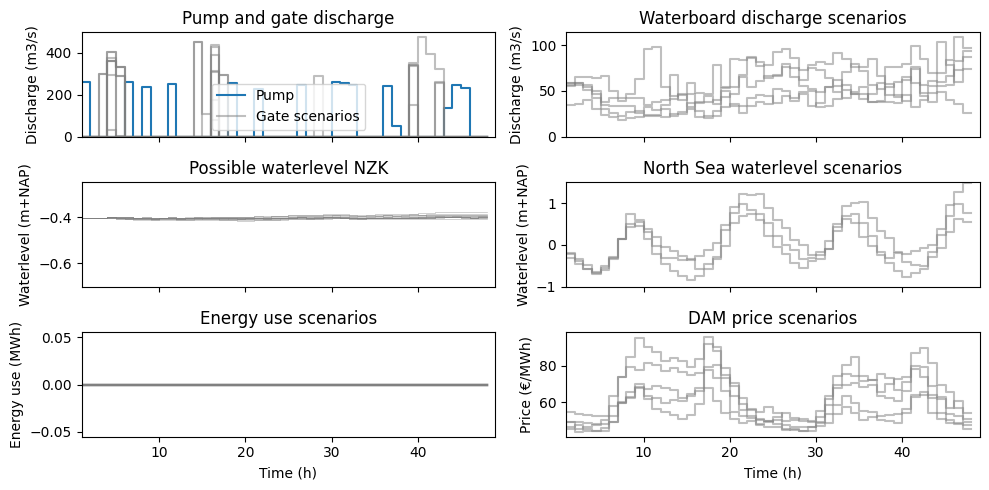

In [93]:
idx = pd.IndexSlice
fig, axes = plt.subplots(3, 2, figsize=(10, 5), sharex=True)
ax=axes[0, 0] # Results
ax.step([t for t in model.model.time], model.q_pump[date].values(), label='Pump')
i=0
for s_wl in range(3):
    for s_q in range(5):
        if i==0:
            label='Gate scenarios'
            i += 1
        else:
            label=None
        ax.step([t for t in model.model.time], model.q_gate[date][s_q+1][s_wl+1].values(), alpha=0.5, color='grey', label=label)
ax.set_ylabel('Discharge (m3/s)')
ax.set_title('Pump and gate discharge')
ax.set_ylim(0, None)
ax.set_xlim(1, 49)
ax.legend(loc='best')

ax=axes[0, 1] # Input
ax.step([t for t in model.model.time], discharge_scenarios.loc[date].T.values[:-1], label='Discharge', alpha=0.5, color='grey')
ax.set_title('Waterboard discharge scenarios')
ax.set_ylim(0, None)
ax.set_ylabel('Discharge (m3/s)')

ax = axes[1, 0]
i=0
for s_wl in range(3):
    for s_q in range(5):
        if i==0:
            label='Waterboard discharge scenarios'
            i += 1
        else:
            label=None
        ax.step([t for t in model.model.time], model.h_nzk[date][s_q+1][s_wl+1].values(), alpha=0.5, color='grey', lw=0.5)

ax.set_ylabel('Waterlevel (m+NAP)')
ax.set_title('Possible waterlevel NZK')
ax.set_ylim(-0.7, -0.25)

ax = axes[1, 1]
ax.step([t for t in model.model.time], waterlevel_scenarios.loc[date].T.values[:-1], label='Waterlevel', alpha=0.5, color='grey')
ax.set_ylim(-1, 1.5)
ax.set_title('North Sea waterlevel scenarios')
ax.set_ylabel('Waterlevel (m+NAP)')


ax = axes[2, 0]
# Plot energy use
for s_wl in range(3):
    for s_q in range(5):
        # ax.step([t for t in model.model.time], [pump_energy(t, s_q, s_wl) for t in model.model.time], alpha=0.5, color='grey')
        ax.step([t for t in model.model.time], model.pump_power[date][s_q+1][s_wl+1].values(), alpha=0.5, color='grey')

ax.set_ylabel('Energy use (MWh)')
ax.set_xlabel('Time (h)')
ax.set_title('Energy use scenarios')

# Plot prices
# ax2 = ax.twinx()
ax = axes[2, 1]
ax.step([t for t in model.model.time], dam_scenarios.loc[date].T.values[:-1], label='Price', color='grey', alpha=0.5)
ax.set_xlabel('Time (h)')
ax.set_title('DAM price scenarios')
ax.set_ylabel('Price (€/MWh)')

fig.tight_layout()

In [55]:
max_wl = []
for s_wl in range(3):
    for s_q in range(5):
        max_wl.append(max(model.h_nzk[date][s_q+1][s_wl+1].values()))

# max_wl = max(max_wl)
print(max_wl)

[-0.38678969348844594, -0.374927523565146, -0.39248062166893743, -0.39977036928016485, -0.4, -0.3928107475575825, -0.38359234062931585, -0.39851652800236026, -0.39977036928016485, -0.4, -0.39292239581822985, -0.39546389385318237, -0.391480920674708, -0.39977036928016485, -0.3994709389249464]


In [111]:
dists = np.array([
    np.arange(i, i+5) for i in range(5)
])

In [112]:
arr = np.array([1, 2])

In [113]:
dists[arr, :][:, arr]

array([[2, 3],
       [3, 4]])

In [75]:
dists

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]])

In [ ]:
model = ConcreteModel()
        model.name = 'IJmuiden'
        
        model.A_nzk = Param(initialize=36*10e6) # m2
        model.dt = Param(initialize=3600) # s
        model.max_wl = Param(initialize=-0.4) # m

        model.time = RangeSet(1, q_scen.shape[1])
        model.discharge_scenarios = RangeSet(1, q_scen.shape[0])
        model.waterlevel_scenarios = RangeSet(1, wl_scen.shape[0])
        model.dam_scenarios = RangeSet(1, dam_scen.shape[0])
        model.lin_qhpump = RangeSet(1, len(self.lin_qh_pump_coefs))

        model.q_weights = Param(model.discharge_scenarios, domain=NonNegativeReals, initialize=q_weights)
        model.wl_weights = Param(model.waterlevel_scenarios, domain=NonNegativeReals, initialize=wl_weights)
        model.dam_weights = Param(model.dam_scenarios, domain=NonNegativeReals, initialize=dam_weights)

        model.h_nzk = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Reals, bounds=(-0.8, -0.2), initialize=-0.4)
        model.q_pump = Var(model.time, domain=NonNegativeReals, bounds=(0, 260), initialize=0)
        model.pump_head = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, bounds=(0, 7), initialize=0)
        model.q_gate = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, bounds=(0, 500), initialize=0)
        model.B_gate = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Binary, initialize=0)
        model.B_pump = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=Binary, initialize=0)

        # model.VaR_wl = Var(model.time, domain=Reals, initialize=0, bounds=(-2, 2))
        model.VaR_wl = Param(model.time, initialize=-0.4)
        model.CVaR_wl_con = Param(initialize=-0.395)
        model.z_wl = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, initialize=0, bounds=(0, 5))
        model.alpha_wl = Param(initialize=self.alpha_wl)
        

        def volume_balance_rule(model, s_q, s_wl, t):
            # q = m3/s
            # h = m
            # A = m2
            # dt = s
            # -> [m] + [1/m2] (m3/s - m3/s - m3/s) * s = [m]
            if t == 1:
                return model.h_nzk[s_q, s_wl, t] == self.h_now + ((1 / model.A_nzk) * (q_scen[s_q-1, t-1] - model.q_pump[t] - model.q_gate[s_q, s_wl, t]) * model.dt)
            else:
                return model.h_nzk[s_q, s_wl, t] == model.h_nzk[s_q, s_wl, t-1] + ((1 / model.A_nzk) * (q_scen[s_q-1, t-1] - model.q_pump[t-1] - model.q_gate[s_q, s_wl, t-1]) * model.dt)
        model.volume_balance_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=volume_balance_rule)

        

        def gate_rule(model, s_q, s_wl, t):
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            return model.q_gate[s_q, s_wl, t] / 500 <= model.B_gate[s_q, s_wl, t] * (self.lin_qh_gate_coefs[0] * dh + self.lin_qh_gate_coefs[1]) / 500
        model.gate_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=gate_rule)

        def binary_gate_rule_upper(model, s_q, s_wl, t):
            # If dh < 0: B=0, if dh >= 0: B=free
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            delta_ijm = 0.12
            return (dh - delta_ijm) + (1 - model.B_gate[s_q, s_wl, t]) * 10 >= 0
        model.binary_gate_con_upper = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=binary_gate_rule_upper)

        def binary_gate_rule_lower(model, s_q, s_wl, t):
            # If dh < 0: B=free, if dh >= 0: B=1
            if t == 1:
                dh = self.h_now - wl_scen[s_wl-1, t-1]
            else:
                dh = model.h_nzk[s_q, s_wl, t-1] - wl_scen[s_wl-1, t-1]
            delta_ijm = 0.12
            return (dh - delta_ijm) - (model.B_gate[s_q, s_wl, t] * 10) <= 0
        model.binary_gate_con_lower = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=binary_gate_rule_lower)

        def binary_pump_rule_upper(model, s_q, s_wl, lin, t):
            # If dh < 0: B=0, if dh >= 0: B=free
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return (dh - 0.01) + (1 - model.B_pump[s_q, s_wl, t]) * 10 >= 0
        model.binary_pump_con_upper = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=binary_pump_rule_upper)

        def binary_pump_rule_lower(model, s_q, s_wl, lin, t):
            # If dh < 0: B=free, if dh >= 0: B=1
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return (dh - 0.01) - (model.B_pump[s_q, s_wl, t] * 10) <= 0
        model.binary_pump_con_lower = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=binary_pump_rule_lower)

        def bin_compl_rule(model, s_q, s_wl, t):
            return model.B_gate[s_q, s_wl, t] + model.B_pump[s_q, s_wl, t] <= 1
        model.bin_compl_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=bin_compl_rule)


        # Define the CVaR constraint
        def cvar_rule(model, t):
            return model.VaR_wl[t] + (1 / (1 - model.alpha_wl)) * sum(model.z_wl[s_q, s_wl, t] \
                * model.q_weights[s_q] * model.wl_weights[s_wl] \
                    for s_q in model.discharge_scenarios for s_wl in model.waterlevel_scenarios) <= model.CVaR_wl_con
        model.cvar_constraint = Constraint(model.time, rule=cvar_rule)

        # Define the z_wl constraint
        def z_wl_rule(model, s_q, s_wl, t):
            return model.z_wl[s_q, s_wl, t] >= model.h_nzk[s_q, s_wl, t] - model.VaR_wl[t] #- model.max_wl
        model.z_wl_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=z_wl_rule)
        
        # model.dhnzk2 = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, within=Reals, bounds=(0,50))
        # def dH2(model, s_q, s_wl, t):
        #     return model.dhnzk2[s_q, s_wl, t] == (wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t])**2
        # model.dh2_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=dH2)

        def pump_head_rule(model, s_q, s_wl, t):
            return model.pump_head[s_q, s_wl, t] == model.B_pump[s_q, s_wl, t]  * (wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t])
        model.pump_head_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.time, rule=pump_head_rule)

        model.power = Var(model.discharge_scenarios, model.waterlevel_scenarios, model.time, domain=NonNegativeReals, initialize=0)
        
        pw_power_func = PiecewiseLinearFunctionND(self.tri, self.points)

        # Add a constraint for every time step
        for s_q in model.discharge_scenarios:
            for s_wl in model.waterlevel_scenarios:
                for t in model.time:
                    setattr(model, 'power_con_{}_{}_{}'.format(s_q, s_wl, t), TransformedPiecewiseLinearFunctionND(f=pw_power_func, output=model.power[s_q, s_wl, t], input=(model.pump_head[s_q, s_wl, t], model.q_pump[t])))

        def pump_rule(model, s_q, s_wl, lin, t):
            if t == 1:
                dh = wl_scen[s_wl-1, t-1] - self.h_now
            else:
                dh = wl_scen[s_wl-1, t-1] - model.h_nzk[s_q, s_wl, t-1]
            return model.q_pump[t] / 260 <= model.B_pump[s_q, s_wl, t] * (self.lin_qh_pump_coefs[lin-1]['a'] * dh + self.lin_qh_pump_coefs[lin-1]['b']) / 260
        model.pump_con = Constraint(model.discharge_scenarios, model.waterlevel_scenarios, model.lin_qhpump, model.time, rule=pump_rule)

        def objective(model):

            def scen_cost(s_dam):
                # Calculate the energy cost for each DAM scenario
                return sum ( sum( sum(model.power[s_q, s_wl, t] * dam_scen[s_dam-1, t-1] for t in model.time) * model.q_weights[s_q] for s_q in model.discharge_scenarios ) * model.wl_weights[s_wl] for s_wl in model.waterlevel_scenarios)
            
            # Minimize the expected energy cost
            return sum(scen_cost(s_dam) * model.dam_weights[s_dam] for s_dam in model.dam_scenarios)

        model.obj = Objective(rule=objective, sense=minimize)

        self.model = model